In [1]:
!pip install transformers

In [3]:
!pip install torch

In [2]:
# Get CoLA dataset from its official source

#!wget https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
#!unzip cola_public_1.1.zip 
#!cp ./cola_public/raw/in_domain_train.tsv .
#!cp ./cola_public/raw/out_of_domain_dev.tsv .

In [2]:
import pandas as pd
import numpy as np
from transformers import RobertaForSequenceClassification,RobertaTokenizer
import torch
import tensorflow as tf
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split

In [4]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_excel('./drive/MyDrive/Roberta_Large_GED_Output/voca_input.xlsx', sheet_name=None, usecols="A,B", header=None, skiprows=1)
df = pd.concat([df.assign(sheet=n) for n,df in df.items()], sort=True)
df.columns = ['sentence','label','sheet']

In [8]:
#df = pd.read_csv("./drive/MyDrive/Roberta_Large_GED_Output/voca_sample.csv", delimiter=',', header=None, names=['sentence', 'label'], encoding='cp1252')

In [9]:
df.head(20)

,sentence,label,sheet
0,One day there were some pirates,1,Standardize – Stand or Die
1,They could never standardize anything,1,Standardize – Stand or Die
2,They couldn’t establish how much their ship w...,0,Standardize – Stand or Die
3,They didn’t know how much their ship could hold,1,Standardize – Stand or Die
4,Then out of nowhere once their captain just s...,0,Standardize – Stand or Die
5,So reluctantly all of the pirates stood,1,Standardize – Stand or Die
6,Unfortunately their fears became true and the...,1,Standardize – Stand or Die
7,They started throwing cargo overboard to stop...,0,Standardize – Stand or Die
8,The ship sank and all they had gained was lost,1,Standardize – Stand or Die
9,Nothing had ended well,1,Standardize – Stand or Die


In [10]:
# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_id = []
attention_masks = []

In [11]:
output_dir = './drive/MyDrive/Roberta/'
tokenizer = RobertaTokenizer.from_pretrained(output_dir)
model_loaded = RobertaForSequenceClassification.from_pretrained(output_dir)

In [12]:
for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
  input_id.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_id, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size) 

In [13]:
model_loaded.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_loaded = model_loaded.to(device)
  b_input_ids = b_input_ids.to(device)
  b_input_mask = b_input_mask.to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():

      # Forward pass, calculate logit predictions
    outputs = model_loaded(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [14]:
flat_predictions = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [15]:
flat_true_labels

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
df['prediction'] = flat_predictions
#df['actual'] = flat_true_labels

In [17]:
df.head(20)

,sentence,label,sheet,prediction
0,One day there were some pirates,1,Standardize – Stand or Die,1
1,They could never standardize anything,1,Standardize – Stand or Die,1
2,They couldn’t establish how much their ship w...,0,Standardize – Stand or Die,0
3,They didn’t know how much their ship could hold,1,Standardize – Stand or Die,1
4,Then out of nowhere once their captain just s...,0,Standardize – Stand or Die,1
5,So reluctantly all of the pirates stood,1,Standardize – Stand or Die,0
6,Unfortunately their fears became true and the...,1,Standardize – Stand or Die,1
7,They started throwing cargo overboard to stop...,0,Standardize – Stand or Die,1
8,The ship sank and all they had gained was lost,1,Standardize – Stand or Die,1
9,Nothing had ended well,1,Standardize – Stand or Die,1


In [18]:
df.to_csv('voca_output_formatted.csv')

In [22]:
!cp voca_output_formatted.csv "drive/My Drive/"

              precision    recall  f1-score   support

   Incorrect       0.16      0.33      0.21         9
     Correct       0.96      0.90      0.93       161

    accuracy                           0.87       170
   macro avg       0.56      0.62      0.57       170
weighted avg       0.92      0.87      0.89       170

AUC:  61.7%


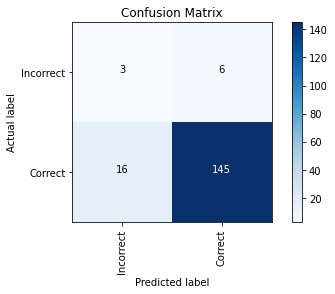

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title, classes=['Incorrect', 'Correct'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '0'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

print(classification_report(flat_true_labels, flat_predictions, target_names=['Incorrect', 'Correct']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(flat_true_labels, flat_predictions)))
cm = confusion_matrix(flat_true_labels, flat_predictions)
plot_confusion_matrix(cm, title="Confusion Matrix", save=True, saveas="IF_SA.png")